In [1]:
import sys
sys.path.append("..")

import networkx as nx
import matplotlib.pyplot as plt
from src.graphgen.synthetic_graph_dataset_PyG import *
from torch_geometric.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.nn import GCNConv, GraphConv, global_mean_pool, global_add_pool

In [2]:
dataset = SyntheticGraphDatasetPyG('graphGenDataset8000.pkl')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')
print(f'Class label: ', data.y)
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges/2}') # divide by 2 because of undirected edges
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: SyntheticGraphDatasetPyG(8000):
Number of graphs: 8000
Number of features: 10

Data(x=[29, 10], edge_index=[2, 220], y=[1])
Class label:  tensor([1])
Number of nodes: 29
Number of edges: 110.0
Average node degree: 7.59
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/Users/kumarh/Documents/fall_co-op_2023/experiments/../src/graphgen/synthetic_graph_dataset_PyG.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/torch/csrc/utils/tensor_new.cpp:233.)
  edge_index = torch.tensor(graph_adj.nonzero(), dtype=torch.long)


nodes: 81
edges: 992
label: 0


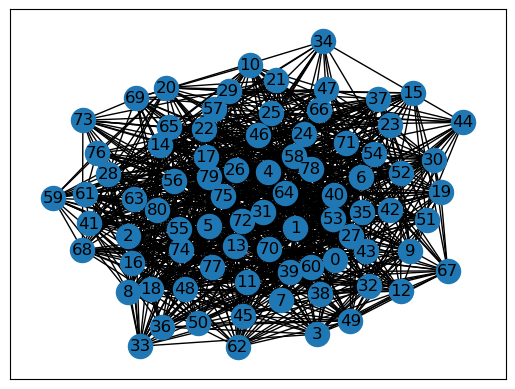

In [3]:
## verify the dataset

with open('graphGenDataset100.pkl', 'rb') as f:
    dd = pickle.load(f)

gg = nx.Graph(dd[0][0])
nx.draw_networkx(gg, pos=nx.spring_layout(gg))

print(f'nodes: {len(gg.nodes())}')
print(f'edges: {len(gg.edges())}')
print(f'label: {dd[0][3]}')


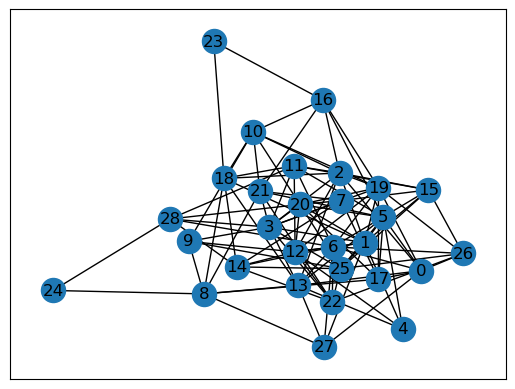

In [4]:
# Convert the PyTorch Geometric Data object to a NetworkX graph
graph = nx.Graph()
graph.add_nodes_from(range(data.num_nodes))
graph.add_edges_from(data.edge_index.t().tolist())

# Visualize the graph
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, pos=pos)
plt.show()

In [5]:
# Split the dataset into training, validation, and testing subsets
num_samples = len(dataset)
num_train = int(0.7 * num_samples)
num_val = int(0.2 * num_samples)
num_test = num_samples - num_train - num_val

train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train, num_val, num_test])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
len(train_dataset), len(val_dataset), len(test_dataset)

(5600, 1600, 800)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [9]:
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = nn.Linear(dim, dim)
        self.lin2 = nn.Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

model = Net(dim=32).to(device)
print(model)

Net(
  (conv1): GraphConv(10, 32)
  (conv2): GraphConv(32, 32)
  (conv3): GraphConv(32, 32)
  (conv4): GraphConv(32, 32)
  (conv5): GraphConv(32, 32)
  (lin1): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)


In [10]:
# Training loop with validation and model checkpointing
best_val_loss = float("inf")  # Track the best validation loss
best_model = None

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 26):
    model.train()
    train_loss = 0
    train_correct = 0

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1)
        train_correct += pred.eq(data.y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)

    model.eval()
    val_loss = 0
    val_correct = 0
    for data in val_loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        val_loss += loss.item()
        pred = output.argmax(dim=1)
        val_correct += pred.eq(data.y).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()  # Save the best model

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

# Load the best model for evaluation
model.load_state_dict(best_model)

Epoch: 001, Train Loss: 15.0559, Train Acc: 0.8545, Val Loss: 0.1358, Val Acc: 0.9750
Epoch: 002, Train Loss: 0.3343, Train Acc: 0.8539, Val Loss: 0.1872, Val Acc: 0.9712
Epoch: 003, Train Loss: 0.2675, Train Acc: 0.9030, Val Loss: 0.2096, Val Acc: 0.9756
Epoch: 004, Train Loss: 0.2062, Train Acc: 0.9363, Val Loss: 0.1070, Val Acc: 0.9769
Epoch: 005, Train Loss: 0.1691, Train Acc: 0.9486, Val Loss: 0.1446, Val Acc: 0.9781
Epoch: 006, Train Loss: 0.1330, Train Acc: 0.9579, Val Loss: 0.1205, Val Acc: 0.9781
Epoch: 007, Train Loss: 0.3444, Train Acc: 0.9241, Val Loss: 0.0978, Val Acc: 0.9738
Epoch: 008, Train Loss: 0.1896, Train Acc: 0.9368, Val Loss: 0.0707, Val Acc: 0.9731
Epoch: 009, Train Loss: 0.2652, Train Acc: 0.9182, Val Loss: 0.0815, Val Acc: 0.9850
Epoch: 010, Train Loss: 0.1757, Train Acc: 0.9445, Val Loss: 0.0676, Val Acc: 0.9794
Epoch: 011, Train Loss: 0.2186, Train Acc: 0.9239, Val Loss: 0.0414, Val Acc: 0.9894
Epoch: 012, Train Loss: 0.1492, Train Acc: 0.9505, Val Loss: 0.0

<All keys matched successfully>

In [12]:
# ... (Use the model for evaluation)
def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

test_acc = test(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7325


In [9]:
from captum.attr import Saliency, IntegratedGradients

input_data = train_dataset[0]
input_data = input_data.to(device) 
baseline_data = torch.zeros_like(input_data)

ig = IntegratedGradients(model)
attributions, delta = ig.attribute(input_data, baseline_data, target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)


TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not Data

In [ ]:
# Convert attributions to a list of scores (modify this to extract the appropriate attributions)
# In this example, we're using the sum of the attributions for each node.
scores = attributions.sum(dim=-1).cpu().numpy()

# Create a NetworkX graph from your input data (modify this to match your data format)
# Assume that input_data is a PyG Data object representing a graph
graph = nx.Graph()
for i in range(input_data.num_nodes):
    graph.add_node(i)

# Add edges based on your graph structure (modify this to match your data format)
# In this example, we assume that input_data.edge_index contains edge information.
edge_list = input_data.edge_index.t().cpu().numpy()
graph.add_edges_from(edge_list)

# Create a dictionary of node colors based on the scores
# The color scale is based on the attributions.
node_colors = [scores[node] for node in graph.nodes()]

# Plot the graph with node colors
pos = nx.spring_layout(graph, seed=42)  # Adjust layout algorithm as needed
plt.figure(figsize=(10, 10))
nx.draw(graph, pos, with_labels=True, node_color=node_colors, cmap=plt.get_cmap('coolwarm'), node_size=300)
plt.colorbar()
plt.title('Graph with IG Attributions')
plt.show()

In [14]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
from captum.attr import IntegratedGradients

# ... (previous code for dataset and model initialization) ...

# Choose a data point from the dataset for interpretation (you can modify this)
data_point = train_dataset[0]
input_data = data_point.to(device)  # Send the data point to the device (e.g., GPU)
batch = input_data.batch  # Batch information (if available)

# Extract the relevant parts of the PyG Data object
x = input_data.x  # Node features (tensor)
edge_index = input_data.edge_index  # Edge indices (tensor)
num_nodes = input_data.num_nodes  # Number of nodes

# Define a baseline data point
baseline_data = torch.zeros_like(x, requires_grad=False).to(device)  # Create a tensor of zeros with the same size

# Create the IG object for your model
ig = IntegratedGradients(model)

# Compute IG attributions
# attributions, _ = ig.attribute(x, baseline_data, target=0, return_convergence_delta=True)
attributions, _ = ig.attribute((x, edge_index, batch), (baseline_data, edge_index, batch), target=0, return_convergence_delta=True)
# Convert attributions to a list of scores (modify this to extract the appropriate attributions)
# In this example, we're using the sum of the attributions for each node.
scores = attributions.sum(dim=-1).cpu().numpy()

# Create a NetworkX graph from your input data (modify this to match your data format)
graph = nx.Graph()
for i in range(num_nodes):
    graph.add_node(i)

# Add edges based on your graph structure (modify this to match your data format)
edge_list = edge_index.t().cpu().numpy()
graph.add_edges_from(edge_list)

# Create a dictionary of node colors based on the scores
# The color scale is based on the attributions.
node_colors = [scores[node] for node in graph.nodes()]

# Plot the graph with node colors
pos = nx.spring_layout(graph, seed=42)  # Adjust layout algorithm as needed
plt.figure(figsize=(10, 10))
nx.draw(graph, pos, with_labels=True, node_color=node_colors, cmap=plt.get_cmap('coolwarm'), node_size=300)
plt.colorbar()
plt.title('Graph with IG Attributions')
plt.show()


AssertionError: baseline input argument must be either a torch.Tensor or a number             however <class 'NoneType'> detected